# Convolutional Neural Net (CNN) - Demo 

## Introduction

The following notebook explains the basic steps to be performed in order to create a convolutional neural network using the Tensorflow machine learning library. This notebook is associated to Damavis' blog article: "Creating a convolutional network using Tensorflow". The main objective of this demo is to present a simple implementation of this type of neural networks. Specifically, we will use this type of networks to detect malaria cases in images.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 5
BATCH_SIZE = 16
IMG_HEIGHT = 28
IMG_WIDTH  = 28
CHANNELS = 3
LR = 0.001

## Data: Malaria Dataset

The dataset used belongs to the [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/malaria?hl=es-419) data catalog. This dataset has been used since the objective of this notebook does not reside in carrying out the preprocessing of them. In this way we obtain an image dataset that meets our desired requirements, clean and focused for the image classification problem.

In the Malaria dataset we represent images of fine blood smear slides of segmented cells. We will have two classes: parasitized cells and uninfected cells.

### A glimpse into data

If we look at the data we are going to use we can see in the following image an example of the different classes of our dataset. On one side we have the images of parasitized cells and on the other side the images of uninfected cells. In our case, the dataset is composed of 19,291 training images and 8,267 test images.

In [3]:
(train_ds, test_ds), info = tfds.load("malaria", 
                                      split=['train[:70%]', 'train[70%:]'], 
                                      shuffle_files=True, 
                                      with_info=True, 
                                      as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteIUB49G/malaria-train.tfrecord


  0%|          | 0/27558 [00:00<?, ? examples/s]

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
print("Name of the classes: " + str(info.features['label'].names))

Name of the classes: ['parasitized', 'uninfected']


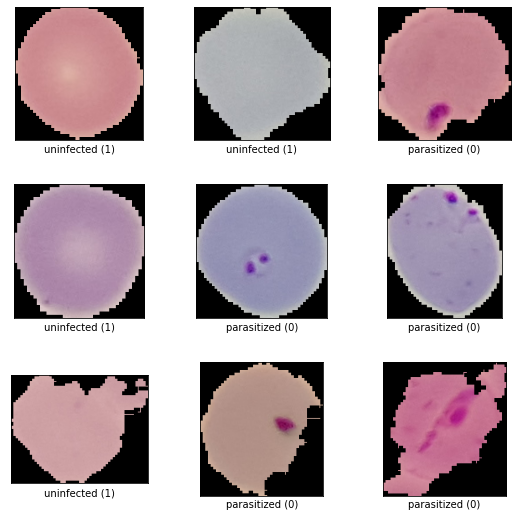

In [5]:
examples = tfds.visualization.show_examples(train_ds, info)

In [6]:
QTY_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
QTY_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()

print("Quantity of training images: " + str(QTY_TRAIN_IMAGES))
print("Quantity of testing  images: " + str(QTY_TEST_IMAGES))

Quantity of training images: 19291
Quantity of testing  images: 8267


## Preprocessing of the dataset

Although the data are already preprocessed and clean we must perform a slight preprocessing to be able to load the data into our model correctly. In this case the most relevant transformation is to resize the image to a common size for the whole dataset. Although it may seem counter-intuitive, a larger number of pixels does not always result in better model performance. In addition, the larger the image dimensions the more pixel sets the network will have to process and therefore the more time consuming it will be.

For the realization of this demo a size of 28x28 pixels is sufficient.

In [7]:
def preprocessing(img, label):
  # Transformamos el tipo de la imagen
  image_converted = tf.image.convert_image_dtype(img, tf.float32)
  # Agregamos padding a la imagen
  image_resized = tf.image.resize(image_converted, (IMG_HEIGHT, IMG_WIDTH))

  return image_resized, label

In [8]:
processed_train_ds = train_ds.cache().map(preprocessing).batch(BATCH_SIZE)
processed_test_ds = test_ds.cache().map(preprocessing).batch(BATCH_SIZE)

uninfected


(-0.5, 27.5, 27.5, -0.5)

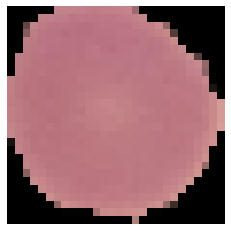

In [9]:
img_processed, label = next(iter(processed_train_ds))
print(info.features['label'].names[label[1]])
plt.imshow(img_processed[1,...])
plt.axis("off")

## Model architecture
At this point we can carry out the construction of our convolutional network. Using Tensorflow it is very easy to define the sequential organization of layers. In this case we will use the layers mentioned in the basic concepts section of this article. 

The network architecture is composed of a first input layer, followed by convolution, max pooling, dropout and dense layers. The convolution layers will extract the characteristic patterns of each image. The max pooling layers will reduce the image dimensions by a process of selecting the highest value in a set of pixels. Finally the dense layers are nothing more than sets of neurons all interconnected with each other, also known as fully connected layers.
The dropout layers will mitigate the overfitting of the model by randomly disconnecting some connections between neurons.

In [10]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        
        tf.keras.layers.Conv2D(filters=16, 
                               kernel_size=3, 
                               activation='relu', 
                               padding='same'),

        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=3, 
                               activation='relu', 
                               padding='same'),

        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [11]:
CNN_model = build_model()

In [12]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1

In [13]:
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

### Training
In this section we have considered to carry out a short training of only 5 iterations or epochs. With only 5 iterations we can already observe that the loss of the model decreases after each one of them and that our evaluation metric increases subtly.
The metric used was the AUC, area under the curve, which defines a type of ROC curve that relates the rate of true positives to that of false positives. The higher its value, the better performance our model will have. It is a commonly used metric in disease detection.

In [14]:
history = CNN_model.fit(
    processed_train_ds, 
    epochs=EPOCHS
)

Epoch 1/5
1206/1206 [==============================] - 32s 25ms/step - loss: 0.5855 - auc: 0.7563
Epoch 2/5
1206/1206 [==============================] - 20s 17ms/step - loss: 0.3093 - auc: 0.9438
Epoch 3/5
1206/1206 [==============================] - 19s 16ms/step - loss: 0.2160 - auc: 0.9708
Epoch 4/5
1206/1206 [==============================] - 19s 16ms/step - loss: 0.1814 - auc: 0.9780
Epoch 5/5
1206/1206 [==============================] - 19s 16ms/step - loss: 0.1687 - auc: 0.9804


### Evaluation

In [15]:
CNN_model.evaluate(processed_test_ds)

517/517 [==============================] - 9s 17ms/step - loss: 0.1610 - auc: 0.9838


[0.16103224456310272, 0.9838152527809143]